# Generate a Noise Model using Calibration Data 

We will use pairs of noisy calibration observations $x_i$ and clean signal $s_i$ (created by averaging these noisy, calibration images) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. 

__Note:__ Noise model can also be generated if calibration data is not available. In such a case, we use an approach called ```Bootstrapping```. Take a look at the notebook ```0b-CreateNoiseModel (With Bootstrapping)``` on how to do so. To understand more about the ```Bootstrapping``` procedure, take a look at the readme [here](https://github.com/juglab/PPN2V).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import os
import urllib
import zipfile
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../../')
from divnoising.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from divnoising import histNoiseModel
from divnoising.utils import plotProbabilityDistribution

In [2]:
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Download data

Download the data from https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1. Here we show the pipeline for Mouse nuclei dataset. Save the dataset in an appropriate path. For us, the path is the data folder which exists at `./data`.

In [3]:
# Download data
if not os.path.isdir('./data'):
    os.mkdir('./data')

zipPath="./data/Mouse_skull_nuclei.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve('https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("./data")

The noise model is a characteristic of your camera and not of the sample. The downloaded data folder contains a set of calibration images (For the Mouse nuclei dataset, it is ```edgeoftheslide_300offset.tif``` showing the edge of a slide and the data to be denoised is named ```example2_digital_offset300.tif```). The calibration images can be anything which is static and imaged multiple times in succession. Thus, the edge of slide works as well. We can either bin the noisy - GT pairs (obtained from noisy calibration images) as a 2-D histogram or fit a GMM distribution to obtain a smooth, parametric description of the noise model.

Specify ```path``` where the noisy calibration data will be loaded from. It is the same path where noise model will be stored when created later, ```dataName``` is the name you wish to have for the noise model,  ```n_gaussian``` to indicate how many Gaussians willbe used for learning a GMM based noise model, ```n_coeff``` for indicating number of polynomial coefficients will be used to patrametrize the mean, standard deviation and weight of GMM noise model. The default settings for ```n_gaussian``` and ```n_coeff``` generally work well for most datasets.

In [5]:
path="./data/Mouse_skull_nuclei/"
observation= imread(path+'edgeoftheslide_300offset.tif') # Load the appropriate calibration data

dataName = 'nuclei' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [6]:
nameHistNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'calibration'

(1, 512, 512)


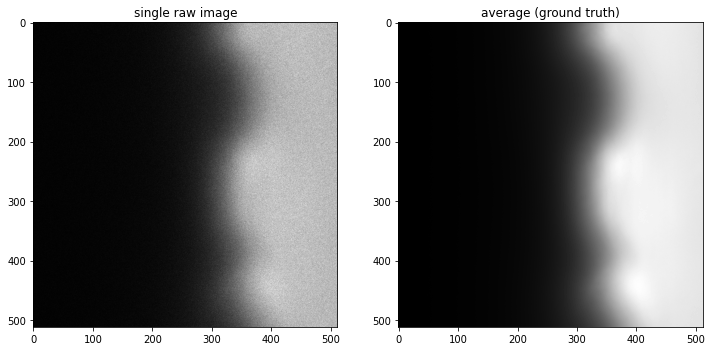

In [7]:
# The data contains 100 images of a static sample (edge of a slide).
# We estimate the clean signal by averaging all images.

signal=np.mean(observation[:, ...],axis=0)[np.newaxis,...]

# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='average (ground truth)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model

Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [8]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
minVal, maxVal = 2000, 22000
bins = 400

# We are creating the histogram.
# This can take a minute.
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

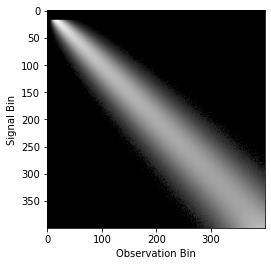

In [9]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [10]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 2926.9
Maximum Signal Intensity is 42559.426


Iterating the noise model training for `n_epoch=4000` and `batchSize=25000` works the best for `Mouse nuclei` dataset. 

In [11]:
gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = min_signal, max_signal =max_signal, 
                                                      path=path, weight = None, n_gaussian = n_gaussian, 
                                                      n_coeff = n_coeff, min_sigma = 50, device = device)

In [12]:
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, 
                                learning_rate=0.1, name = nameGMMNoiseModel)

0 19.19615364074707
100 8.168993949890137
200 8.141515731811523
300 8.130805015563965
400 8.1409912109375
500 8.134590148925781
600 8.138687133789062
700 8.124266624450684
800 8.133844375610352
900 8.137228965759277
1000 8.14219856262207
1100 8.135964393615723
1200 8.139418601989746
1300 8.130520820617676
1400 8.137386322021484
1500 8.129325866699219
1600 8.123997688293457
1700 8.130087852478027
1800 8.142531394958496
1900 8.13622760772705
2000 8.135380744934082
2100 8.147665023803711
2200 8.13261604309082
2300 8.123125076293945
2400 8.13657283782959
2500 8.122945785522461
2600 8.136813163757324
2700 8.12816333770752
2800 8.140355110168457
2900 8.140910148620605
3000 8.129623413085938
3100 8.132704734802246
3200 8.133123397827148
3300 8.133472442626953
3400 8.137773513793945
3500 8.13158893585205
3600 8.133968353271484
3700 8.134095191955566
3800 8.143763542175293
3900 8.134751319885254

The trained parameters (GMMNoiseModel_nuclei_3_2_calibration) is saved at location: ./data/Mouse_sk

### Visualizing the Histogram-based and GMM-based noise models

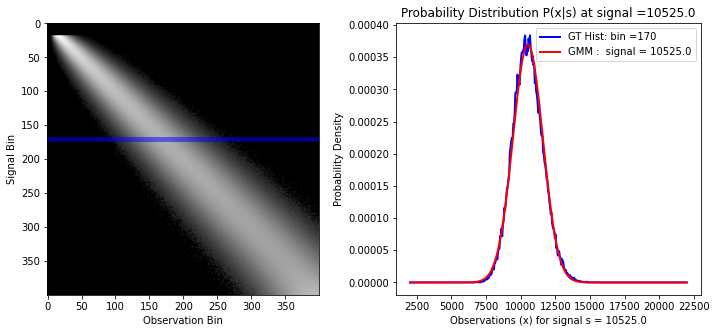

In [13]:
plotProbabilityDistribution(signalBinIndex=170, histogram=histogramFD, 
                            gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, 
                            max_signal=maxVal, n_bin= bins, device=device)